# CIFAR-10 with Ray Train

This demo walks you through the lifecycle of deep learning training job from beginning to end.

At a high level, we will go through 3 steps:
1. Run your training script as a non-distributed script, locally.
2. Convert the script to run with Ray Train in a distributed manner, again locally.
3. Run the same script in a distributed manner, on a cluster with GPUs.

In [1]:
%load_ext autoreload
%autoreload 2

## Local Non-Distributed Training

Let's start by running our training function. Note that we pass in two configuration values:
1. `"test_mode": True`: This cuts down the training and test datasets to 64 records (from 5000 and 1000).
2. `"num_epochs": 10`: We will train for just 10 epochs to verify it's running.

While it's running, we can dive into the code a bit.

In [2]:
from utils import train_func
import time

start_time=time.time()
results = train_func(config={"test_mode": True, "num_epochs": 10})
print(f"--- Finished training in {time.time() - start_time} seconds ---")

Config: {'test_mode': True, 'num_epochs': 10, 'batch_size': 32, 'lr': 0.01, 'max_lr': 0.8, 'momentum': 0.9, 'weight_decay': 0.0001}
Files already downloaded and verified
Epoch 0 | Start
Epoch 0 | Training results: {'train_loss': 4.8587037324905396}
Epoch 0 | Validation results: {'val_loss': 26706.51171875, 'val_accuracy': 0.03125}
Epoch 1 | Start
Epoch 1 | Training results: {'train_loss': 79.66653442382812}
Epoch 1 | Validation results: {'val_loss': 6.078828476142088e+29, 'val_accuracy': 0.109375}
Epoch 2 | Start
Epoch 2 | Training results: {'train_loss': 54.74138069152832}
Epoch 2 | Validation results: {'val_loss': 3.840888263905112e+26, 'val_accuracy': 0.109375}
Epoch 3 | Start
Epoch 3 | Training results: {'train_loss': 57.359609603881836}
Epoch 3 | Validation results: {'val_loss': 2.549854679834078e+22, 'val_accuracy': 0.09375}
Epoch 4 | Start
Epoch 4 | Training results: {'train_loss': 81.64751434326172}
Epoch 4 | Validation results: {'val_loss': 7796286375854080.0, 'val_accuracy': 

In [3]:
results

{'train_loss': 2.5118885040283203,
 'val_loss': 233380.046875,
 'val_accuracy': 0.09375,
 'model_state_dict': OrderedDict([('conv1.weight',
               tensor([[[[-3.2237e+00, -3.2403e+00, -5.6011e+00],
                         [-4.6637e-01, -5.7893e-02, -2.3832e+00],
                         [-5.1794e+00, -5.1455e+00, -7.4045e+00]],
               
                        [[ 6.1310e+00,  6.7199e+00,  4.0344e+00],
                         [ 5.0567e+00,  5.7135e+00,  3.3053e+00],
                         [-2.4150e+00, -2.7117e+00, -4.8500e+00]],
               
                        [[ 8.4966e+00,  9.3650e+00,  6.9725e+00],
                         [ 6.6403e+00,  6.9747e+00,  4.9945e+00],
                         [-1.3767e+00, -1.2925e+00, -3.5962e+00]]],
               
               
                       [[[-1.2778e+01, -9.9824e+00, -7.9685e+00],
                         [-8.2290e+00, -6.1665e+00, -4.8597e+00],
                         [-8.5742e+00, -7.5289e+00, -6.0562e+00]],

Now that we've "trained" a model, let's test it!

In [4]:
from utils import get_model, get_test_data, predict_and_display

In [5]:
model_state_dict = results["model_state_dict"]
model = get_model(model_state_dict)

In [6]:
test_images, test_labels = get_test_data(20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


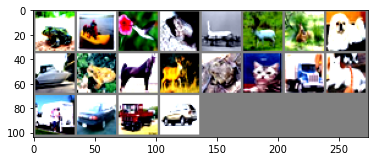

Labels:  tensor([6, 8, 2, 6, 0, 4, 4, 5, 8, 6, 7, 4, 6, 3, 9, 3, 9, 1, 9, 1])
Labels:  frog  ship  bird  frog  plane deer  deer  dog   ship  frog  horse deer  frog  cat   truck cat   truck car   truck car  

Predictions:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2])
Predictions:  bird  bird  bird  bird  bird  bird  bird  bird  bird  bird  bird  bird  bird  bird  bird  bird  cat   bird  bird  bird 

Predicted 1/20 correctly. Accuracy: 5%.


In [7]:
predict_and_display(model, test_images, test_labels)

## Local Distributed Training

Now that we have a working training function, our next step is to distribute it. This is where we'll start using Ray Train.

To move to Ray Train, let's revisit the python script and uncomment out the Ray Train utility functions.

Now that our training function is set up, we'll now need to set up a Ray Train `Trainer`, the main class you will interface with.

In [8]:
from ray.train import Trainer
trainer = Trainer(backend="torch", num_workers=2, logdir="~/workspace/scratch/cifar10/results/local")

A quick summary of the arguments:
1. `backend="torch"` - Distributed PyTorch environment will be set up on the worker processes.
2. `num_workers=2` - Training will be split across two worker processes.
3. (optional) `logdir="~/workspace/scratch/cifar10/results/local"` - Setup logs locally for easier viewing.

After setting up the `Trainer`, we call `start` to start the worker processes.

In [9]:
trainer.start()

(BaseWorkerMixin pid=6358) 2022-02-08 21:55:40,450	INFO torch.py:67 -- Setting up process group for: env:// [rank=1, world_size=2]
(BaseWorkerMixin pid=6363) 2022-02-08 21:55:40,450	INFO torch.py:67 -- Setting up process group for: env:// [rank=0, world_size=2]


Now that we have 2 workers up, let's run the updated training function!

In [10]:
start_time=time.time()
trainer.run(train_func, config={"test_mode": True, "num_epochs": 10})
print(f"--- Finished training in {time.time() - start_time} seconds ---")

2022-02-08 21:55:51,628	INFO trainer.py:196 -- Run results will be logged in: /Users/matt/workspace/scratch/cifar10/results/local/run_001


(BaseWorkerMixin pid=6358) Config: {'test_mode': True, 'num_epochs': 10, 'batch_size': 32, 'lr': 0.01, 'max_lr': 0.8, 'momentum': 0.9, 'weight_decay': 0.0001}
(BaseWorkerMixin pid=6358) World size: 2.  Worker batch size: 16.
(BaseWorkerMixin pid=6363) Config: {'test_mode': True, 'num_epochs': 10, 'batch_size': 32, 'lr': 0.01, 'max_lr': 0.8, 'momentum': 0.9, 'weight_decay': 0.0001}
(BaseWorkerMixin pid=6363) World size: 2.  Worker batch size: 16.


(BaseWorkerMixin pid=6358) 2022-02-08 21:55:53,875	INFO torch.py:239 -- Moving model to device: cpu
(BaseWorkerMixin pid=6358) 2022-02-08 21:55:53,876	INFO torch.py:242 -- Wrapping provided model in DDP.
(BaseWorkerMixin pid=6363) 2022-02-08 21:55:53,871	INFO torch.py:239 -- Moving model to device: cpu
(BaseWorkerMixin pid=6363) 2022-02-08 21:55:53,872	INFO torch.py:242 -- Wrapping provided model in DDP.


(BaseWorkerMixin pid=6363) Files already downloaded and verified
(BaseWorkerMixin pid=6363) Epoch 0 | Start
(BaseWorkerMixin pid=6358) Files already downloaded and verified
(BaseWorkerMixin pid=6358) Epoch 0 | Start
(BaseWorkerMixin pid=6358) Epoch 0 | Training results: {'train_loss': 5.782874226570129}
(BaseWorkerMixin pid=6363) Epoch 0 | Training results: {'train_loss': 6.052669048309326}
(BaseWorkerMixin pid=6358) Epoch 0 | Validation results: {'val_loss': 46638.201171875, 'val_accuracy': 0.09375}
(BaseWorkerMixin pid=6363) Epoch 0 | Validation results: {'val_loss': 36877.71875, 'val_accuracy': 0.09375}
(BaseWorkerMixin pid=6358) Epoch 1 | Start
(BaseWorkerMixin pid=6363) Epoch 1 | Start
(BaseWorkerMixin pid=6358) Epoch 1 | Training results: {'train_loss': 67.44419479370117}
(BaseWorkerMixin pid=6363) Epoch 1 | Training results: {'train_loss': 86.54835510253906}
(BaseWorkerMixin pid=6358) Epoch 1 | Validation results: {'val_loss': 2.4312173530857243e+28, 'val_accuracy': 0.0}
(BaseWo

Let's take a look at some of the attributes that can be accessed after training.

In [11]:
trainer.latest_run_dir

PosixPath('/Users/matt/workspace/scratch/cifar10/results/local/run_001')

In [12]:
trainer.latest_checkpoint_dir

PosixPath('/Users/matt/workspace/scratch/cifar10/results/local/run_001/checkpoints')

In [13]:
trainer.latest_checkpoint

{'epoch': 9,
 'accuracy': 0.09375,
 'model_state_dict': OrderedDict([('bn1.bias',
               tensor([-5.2892,  3.8621, -3.6859, -1.4194, -5.9169,  4.5071,  1.0633,  0.3904,
                       -0.9149, -0.2553,  2.9094, -1.4076, -1.4208, -4.9704, -8.2704, -1.0818,
                        2.9151, -2.2208, -7.6285, -6.1110,  0.2045, -4.3866,  5.6144,  2.8374,
                       -5.5998,  1.6982,  0.9316,  4.9749,  3.7363, -4.1393, -0.7978, -4.2763,
                       -2.0246, -2.7413,  3.2504, -3.1207, -2.4413,  0.5610,  3.2410, -8.6882,
                       -0.2434,  1.9383, -5.7355, -6.4587,  4.4389, -1.2211,  1.9216, -1.0726,
                       -1.6475, -3.5339,  1.1438,  6.7330, -1.6789,  1.6953,  0.3172,  0.0302,
                        2.2174, -1.6199, -1.2035,  1.5210,  0.2970,  3.8779, -0.8203,  0.0922])),
              ('bn1.num_batches_tracked', tensor(20)),
              ('bn1.running_mean',
               tensor([  1.6725,  -3.3872, -17.9252,   7.0782,  -

Now let's try _this_ "trained" model.

In [14]:
checkpoint = trainer.latest_checkpoint
model_state_dict = checkpoint["model_state_dict"]

In [15]:
model = get_model(model_state_dict)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


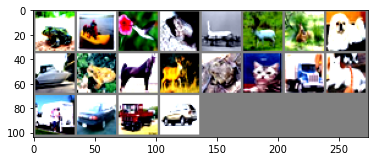

Labels:  tensor([6, 8, 2, 6, 0, 4, 4, 5, 8, 6, 7, 4, 6, 3, 9, 3, 9, 1, 9, 1])
Labels:  frog  ship  bird  frog  plane deer  deer  dog   ship  frog  horse deer  frog  cat   truck cat   truck car   truck car  

Predictions:  tensor([2, 3, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
Predictions:  bird  cat   truck bird  bird  bird  bird  bird  bird  bird  bird  bird  bird  bird  bird  bird  bird  bird  bird  bird 

Predicted 0/20 correctly. Accuracy: 0%.


In [16]:
predict_and_display(model, test_images, test_labels)

To end this step, we'll clean up the worker processes and resources.

In [17]:
trainer.shutdown()

## GPU Cluster Distributed Training

At this point, we've verified that our code runs locally (and distributedly!) for a small subset of the data. But what we _really_ want is to scale up to a cluster of GPUs so that we can train on the entire dataset.

Let's setup that Ray Cluster!

In [18]:
# %load cluster-config.yaml
cluster_name: cifar10

max_workers: 8

provider:
    type: aws
    region: us-west-1

available_node_types:
    cpu-node:
        min_workers: 0
        max_workers: 0
        node_config:
            InstanceType: m5.4xlarge
        resources: {}
    1-gpu-node:
        min_workers: 8
        max_workers: 8
        node_config:
            InstanceType: g4dn.xlarge
            InstanceMarketOptions:
                MarketType: spot
        resources: {}

head_node_type: cpu-node

setup_commands:
    - pip install ray[default] torch torchvision


In a separate terminal:
```bash
# Launch your cluster
$ ray up cluster-config.yaml

# SSH into the cluster and enable port forwarding
$ ray attach cluster-config.yaml -p 10001
```

At this point, you're ready to run your script on the cluster!

In [20]:
import ray
ray_address="ray://localhost:10001"
# ray_address="anyscale://my-cluster"
ray.init(address=ray_address, runtime_env={"working_dir": ".", "excludes":["data", "results"]})

2022-02-08 22:03:00,598	INFO packaging.py:354 -- Creating a file package for local directory '.'.
2022-02-08 22:03:00,724	INFO packaging.py:222 -- Pushing file package 'gcs://_ray_pkg_38f6b7f962d78b5d.zip' (27.14MiB) to Ray cluster...
2022-02-08 22:03:41,110	INFO packaging.py:225 -- Successfully pushed file package 'gcs://_ray_pkg_38f6b7f962d78b5d.zip'.


ClientContext(dashboard_url='127.0.0.1:8265', python_version='3.7.7', ray_version='1.10.0', ray_commit='5ea565317a8104c04ae7892bb9bb41c6d72f12df', protocol_version='2021-12-07', _num_clients=1, _context_to_restore=<ray.util.client._ClientContext object at 0x7f89981c5290>)

In [21]:
trainer = Trainer(backend="torch", num_workers=8, use_gpu=True, logdir="~/workspace/scratch/cifar10/results/cluster")

2022-02-08 22:03:51,919	INFO trainer.py:190 -- Trainer logs will be logged in: /Users/matt/workspace/scratch/cifar10/results/cluster


In [22]:
trainer.start()

(BaseWorkerMixin pid=4815, ip=10.0.1.173) 2022-02-09 06:04:03,758	INFO torch.py:67 -- Setting up process group for: env:// [rank=5, world_size=8]
(BaseWorkerMixin pid=4815, ip=10.0.1.132) 2022-02-09 06:04:03,756	INFO torch.py:67 -- Setting up process group for: env:// [rank=0, world_size=8]
(BaseWorkerMixin pid=4817, ip=10.0.1.185) 2022-02-09 06:04:03,751	INFO torch.py:67 -- Setting up process group for: env:// [rank=3, world_size=8]
(BaseWorkerMixin pid=4875, ip=10.0.1.175) 2022-02-09 06:04:03,754	INFO torch.py:67 -- Setting up process group for: env:// [rank=2, world_size=8]
(BaseWorkerMixin pid=4828, ip=10.0.1.137) 2022-02-09 06:04:03,748	INFO torch.py:67 -- Setting up process group for: env:// [rank=7, world_size=8]
(BaseWorkerMixin pid=4852, ip=10.0.1.176) 2022-02-09 06:04:03,778	INFO torch.py:67 -- Setting up process group for: env:// [rank=4, world_size=8]
(BaseWorkerMixin pid=4827, ip=10.0.1.161) 2022-02-09 06:04:03,763	INFO torch.py:67 -- Setting up process group for: env:// [

In [23]:
from ray.train.callbacks import JsonLoggerCallback, TBXLoggerCallback

# Scale it up!
config = {"batch_size": 1024, "lr": 0.1, "num_epochs": 100}
callbacks = [JsonLoggerCallback(), TBXLoggerCallback()]

trainer.run(train_func, config=config, callbacks=callbacks)

2022-02-08 22:04:15,114	INFO trainer.py:196 -- Run results will be logged in: /Users/matt/workspace/scratch/cifar10/results/cluster/run_001


(BaseWorkerMixin pid=4815, ip=10.0.1.173) Config: {'batch_size': 1024, 'lr': 0.1, 'num_epochs': 100, 'max_lr': 0.8, 'momentum': 0.9, 'weight_decay': 0.0001, 'test_mode': False}
(BaseWorkerMixin pid=4815, ip=10.0.1.173) World size: 8.  Worker batch size: 128.
(BaseWorkerMixin pid=4852, ip=10.0.1.176) Config: {'batch_size': 1024, 'lr': 0.1, 'num_epochs': 100, 'max_lr': 0.8, 'momentum': 0.9, 'weight_decay': 0.0001, 'test_mode': False}
(BaseWorkerMixin pid=4852, ip=10.0.1.176) World size: 8.  Worker batch size: 128.
(BaseWorkerMixin pid=4827, ip=10.0.1.161) Config: {'batch_size': 1024, 'lr': 0.1, 'num_epochs': 100, 'max_lr': 0.8, 'momentum': 0.9, 'weight_decay': 0.0001, 'test_mode': False}
(BaseWorkerMixin pid=4827, ip=10.0.1.161) World size: 8.  Worker batch size: 128.
(BaseWorkerMixin pid=4815, ip=10.0.1.132) Config: {'batch_size': 1024, 'lr': 0.1, 'num_epochs': 100, 'max_lr': 0.8, 'momentum': 0.9, 'weight_decay': 0.0001, 'test_mode': False}
(BaseWorkerMixin pid=4815, ip=10.0.1.132) Worl

(BaseWorkerMixin pid=4827, ip=10.0.1.161) 2022-02-09 06:04:30,114	INFO torch.py:239 -- Moving model to device: cuda:0
(BaseWorkerMixin pid=4815, ip=10.0.1.132) 2022-02-09 06:04:30,130	INFO torch.py:239 -- Moving model to device: cuda:0
(BaseWorkerMixin pid=4875, ip=10.0.1.175) 2022-02-09 06:04:30,135	INFO torch.py:239 -- Moving model to device: cuda:0
(BaseWorkerMixin pid=4828, ip=10.0.1.137) 2022-02-09 06:04:30,123	INFO torch.py:239 -- Moving model to device: cuda:0
(BaseWorkerMixin pid=4817, ip=10.0.1.185) 2022-02-09 06:04:30,127	INFO torch.py:239 -- Moving model to device: cuda:0
(BaseWorkerMixin pid=4772, ip=10.0.1.166) 2022-02-09 06:04:30,123	INFO torch.py:239 -- Moving model to device: cuda:0
(BaseWorkerMixin pid=4815, ip=10.0.1.173) 2022-02-09 06:04:30,146	INFO torch.py:239 -- Moving model to device: cuda:0
(BaseWorkerMixin pid=4852, ip=10.0.1.176) 2022-02-09 06:04:30,152	INFO torch.py:239 -- Moving model to device: cuda:0
(BaseWorkerMixin pid=4827, ip=10.0.1.161) 2022-02-09 06:

(BaseWorkerMixin pid=4772, ip=10.0.1.166) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to data/cifar-10-python.tar.gz
(BaseWorkerMixin pid=4852, ip=10.0.1.176) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to data/cifar-10-python.tar.gz
(BaseWorkerMixin pid=4827, ip=10.0.1.161) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to data/cifar-10-python.tar.gz
(BaseWorkerMixin pid=4815, ip=10.0.1.132) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to data/cifar-10-python.tar.gz
(BaseWorkerMixin pid=4875, ip=10.0.1.175) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to data/cifar-10-python.tar.gz
(BaseWorkerMixin pid=4828, ip=10.0.1.137) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to data/cifar-10-python.tar.gz
(BaseWorkerMixin pid=4817, ip=10.0.1.185) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to data/cifar-10-python.tar.gz
(BaseWorkerMi

 86%|████████▌ | 146080768/170498071 [00:08<00:01, 16595793.65it/s]
170499072it [00:09, 18835722.19it/s]                               
 37%|███▋      | 62866432/170498071 [00:09<00:06, 16546333.67it/s]
170499072it [00:09, 18930957.33it/s]                               
 87%|████████▋ | 148489216/170498071 [00:09<00:01, 18269947.16it/s]
170499072it [00:09, 18719690.09it/s]                               
170499072it [00:09, 18772373.67it/s]                               
 90%|█████████ | 153535488/170498071 [00:09<00:00, 21182252.02it/s]


(BaseWorkerMixin pid=4815, ip=10.0.1.132) Extracting data/cifar-10-python.tar.gz to data
(BaseWorkerMixin pid=4817, ip=10.0.1.185) Extracting data/cifar-10-python.tar.gz to data
(BaseWorkerMixin pid=4828, ip=10.0.1.137) Extracting data/cifar-10-python.tar.gz to data
(BaseWorkerMixin pid=4875, ip=10.0.1.175) Extracting data/cifar-10-python.tar.gz to data


  5%|▌         | 8537088/170498071 [00:09<03:12, 842649.86it/s]
170499072it [00:09, 17102972.73it/s]                               
  5%|▌         | 8939520/170498071 [00:10<03:00, 894785.44it/s]


(BaseWorkerMixin pid=4852, ip=10.0.1.176) Extracting data/cifar-10-python.tar.gz to data


 80%|███████▉  | 135547904/170498071 [00:11<00:01, 24798492.39it/s]


(BaseWorkerMixin pid=4817, ip=10.0.1.185) Epoch 0 | Start
(BaseWorkerMixin pid=4815, ip=10.0.1.132) Epoch 0 | Start
(BaseWorkerMixin pid=4828, ip=10.0.1.137) Epoch 0 | Start
(BaseWorkerMixin pid=4875, ip=10.0.1.175) Epoch 0 | Start


 94%|█████████▍| 161022976/170498071 [00:12<00:00, 25136344.78it/s]
170499072it [00:12, 13231690.38it/s]                               
 96%|█████████▌| 163538944/170498071 [00:13<00:00, 24588158.51it/s]


(BaseWorkerMixin pid=4852, ip=10.0.1.176) Epoch 0 | Start


 39%|███▉      | 66798592/170498071 [00:13<00:04, 25394145.80it/s]
170499072it [00:13, 12762723.89it/s]                               


(BaseWorkerMixin pid=4815, ip=10.0.1.173) Extracting data/cifar-10-python.tar.gz to data


 45%|████▌     | 77360128/170498071 [00:13<00:03, 24621372.55it/s]


(BaseWorkerMixin pid=4772, ip=10.0.1.166) Extracting data/cifar-10-python.tar.gz to data


 79%|███████▉  | 134577152/170498071 [00:15<00:01, 24523397.20it/s]


(BaseWorkerMixin pid=4815, ip=10.0.1.173) Epoch 0 | Start


 82%|████████▏ | 139915264/170498071 [00:16<00:01, 24842728.71it/s]


(BaseWorkerMixin pid=4772, ip=10.0.1.166) Epoch 0 | Start


 99%|█████████▉| 168641536/170498071 [00:17<00:00, 25293913.00it/s]
170499072it [00:17, 9785476.47it/s]                                


(BaseWorkerMixin pid=4827, ip=10.0.1.161) Extracting data/cifar-10-python.tar.gz to data
(BaseWorkerMixin pid=4827, ip=10.0.1.161) Epoch 0 | Start
(BaseWorkerMixin pid=4772, ip=10.0.1.166) Epoch 0 | Training results: {'train_loss': 4.676752036132813}
(BaseWorkerMixin pid=4815, ip=10.0.1.173) Epoch 0 | Training results: {'train_loss': 4.741828602676391}
(BaseWorkerMixin pid=4852, ip=10.0.1.176) Epoch 0 | Training results: {'train_loss': 4.6296754622650145}
(BaseWorkerMixin pid=4815, ip=10.0.1.132) Epoch 0 | Training results: {'train_loss': 5.508924292068482}
(BaseWorkerMixin pid=4875, ip=10.0.1.175) Epoch 0 | Training results: {'train_loss': 4.930326020584107}
(BaseWorkerMixin pid=4827, ip=10.0.1.161) Epoch 0 | Training results: {'train_loss': 5.032053555755615}
(BaseWorkerMixin pid=4828, ip=10.0.1.137) Epoch 0 | Training results: {'train_loss': 4.852440763473511}
(BaseWorkerMixin pid=4817, ip=10.0.1.185) Epoch 0 | Training results: {'train_loss': 4.565181604537964}
(BaseWorkerMixin pid

[None, None, None, None, None, None, None, None]

In [24]:
! tensorboard dev upload --one_shot --logdir /Users/matt/workspace/scratch/cifar10/results/cluster/run_001 --name cifar10-demo


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/Nkzi5zr2T5CrCPL2BYNKRA/

[2022-02-08T23:08:48] Started scanning logdir.
[2022-02-08T23:08:49] Total uploaded: 600 scalars, 0 tensors, 0 binary objects
[2022-02-08T23:08:49] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/Nkzi5zr2T5CrCPL2BYNKRA/


In [ ]:
trainer.latest_checkpoint

In [ ]:
checkpoint = trainer.latest_checkpoint
model_state_dict = checkpoint["model_state_dict"]
model = get_model(model_state_dict)

In [ ]:
predict_and_display(model, test_images, test_labels)

In [ ]:
trainer.shutdown()